# Demo program for calculating efficiency and transmission functions for thermal baths

The purpose of this notebook is to try and calculate the efficiency and power outputs for a two terminal system coupled to thermal baths. The asssumption is that the right bath (R) is colder than the left bath (L), and has a higher electrochemical potential. We are limiting to heat engines, thus we should get a heat and electric current flow from L to R which generates power. Since the process is governed by the temperature and potential bias, the corresponding quantities for L and R are expressed in terms of the biases and the reference, where the temperature and potential at R are references.

$$
\Delta T = T_L - T_R \geq 0 \implies T_R = T, \: T_L = T +  \Delta T \\
\Delta \mu = \mu_L - \mu_R \leq 0 \implies \mu_R = \mu, \: \mu_L = \mu + \Delta \mu
$$

In addition, the reference potential is set to zero, while the temperature is measured after absolute zero. By default, $h = e = 1$, while $k_B$ has units meV/K. Note that we also assume $V = \mu$ with positive $e$, letting the voltage and potential bias have the same sign. One can just multiply the electric current and the bias by minus one if necessary, but here we are considering particle flow, not charge flow. As such, a negative current means that electrons are **leaving** the corresponding bath, which means that the charge current is positive. 

## Transmission function

The core task of this demo is to adapt the transmission function to maximize power or efficiency with regards to a given efficiency or power respectively. For exchange between two thermal baths, it is well known that the ideal transmission function is a band pass, which simply lets through electrons between two energies, $E_0$ and $E_1$, while blocking all others. The balance between power output and efficiency is encoded in the width of the band pass. For a function that tends to the delta function around the exchange energy, 

$$
E^* = \frac{T_L \mu_R - T_R \mu_L}{T_L - T_R},
$$

the efficiency tends to Carnot efficieny. Conversely, a band pass where $E_0 = E^*$ and $E_1$ tends to infinity maximizes power output at the cost of efficieny (but the efficiency does not necessarily tend to zero!). This is highly reasonable, since this allows for all energies at which more electrons leave L than arrive from R according to their Fermi distributions.

While it is possible to simply maximize the power output, maximizing the efficieny without consideration of the power gives a poorly defined problem, since the power output tends to zero when the efficiency tends to Carnot efficieny, equivalently to a reversible process (at least this seems true for this thermal setup). While the program tends to give the correct function, a delta function centered at the exchange energy, the actual value of the efficiency fluctuates highly, as the power output fluctuates around zero, between positive and negative.

## Thermodynamic laws check

It is important to check that the first and second thermodynamic laws are fulfilled to assure numerical stability.


In [85]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import mpmath as mp

from scipy.optimize import minimize

In [86]:
# Global constants
h = 1#6.6260688e-34 #J/s
e = 1#1.60227646e-19 #C
kb = 1#8.617342e-2#meV/K 1.380650e-23 #J/K
optim= False

In [87]:
#Define global ranges and constants
mu = 0
T = 1
r_deltamu = np.flip(np.linspace(-2, 0,100))
r_deltaT = np.linspace(0,2, 100)
E0_set = 10; E1_set = 1000

r_TL = T+r_deltaT/2
#_TR = np.ones_like(r_TL)*T
r_TR = T-r_deltaT/2

muR = mu
r_muL = mu + r_deltamu

#r_E = np.linspace(E0,E1,100)
print(kb*T)
#print(np.sum(r_E - r_deltamu, axis = 1))


1


In [103]:
#Define functions
def fermi_dist(E, mu, T):
    f_dist = 1/(1+np.exp((E-mu)/(T*kb)))
    return f_dist

def fermi_integrated(E0,E1, mu, T, type="electric"):
    den = kb*T
    if type == "electric":
        integ = -E0 + E1 + kb*T*np.log((np.exp(E0/den)+np.exp(mu/den))/(np.exp(E1/den)+np.exp(mu/den)))
    elif type == "heat":
        integ = mu*(E0+E1+kb*T*np.log((np.exp(E0/den)+np.exp(mu/den))/(np.exp(E1/den)+np.exp(mu/den)))) + \
                kb*T*(E0*np.log(1+np.exp((mu-E0)/den)) - E1*np.log(1+np.exp((mu-E1)/den)) 
                      - kb*T*mp.polylog(2,-np.exp((mu-E0)/den)) + kb*T*mp.polylog(2,-np.exp((mu-E1)/den)))
    elif type == "energy":
        integ = kb*T*(E0*np.log(1+np.exp((mu-E0)/den)) - E1*np.log(1+np.exp((mu-E1)/den)) 
                      - kb*T*mp.polylog(2,-np.exp((mu-E0)/den)) + kb*T*mp.polylog(2,-np.exp((mu-E1)/den)))
    else:
        print("Invalid current type")
        return -1
    return integ

def current_integral(E0, E1, muL, TL, muR, TR, transf, occupf = fermi_dist, type = "electric"):
    if type == "electric":
        coeff = lambda E: e
    elif type == "heat":
        coeff = lambda E: (E-muL)
    elif type == "heatR":
        coeff = lambda E: (E-muR)
    elif type == "energy":
        coeff = lambda E: E
    else:
        print("Invalid current type")
        return -1
    if type == "heatR":
        integrand = lambda E: 1/h*coeff(E)*transf(E)*(-occupf(E,muL,TL)+ occupf(E,muR,TR))
    else:    
        integrand = lambda E: 1/h*coeff(E)*transf(E)*(occupf(E,muL,TL)- occupf(E,muR,TR))
    
    # If we have a delta function?
    #if E1 - E0 < 1:
    #    return integrand((E0+E1)/2)*(E0+E1)/2

    current, err = integrate.quad(integrand, E0, E1, args=())
    return current

def simple_current(E0,E1, muL, TL, muR, TR, type = "electric", N=1, method = "integrate"):
    if method == "integrate":
        def transf(E):
            #return N*(np.heaviside(E-E0,1)*np.heaviside(E1-E,1))
            return N
        return current_integral(E0,E1, muL, TL, muR, TR, transf, type = type)
    if type == "heatR":
        current = 1/h*N*(-fermi_integrated(E0,E1,muL,TL, type = "heat") + fermi_integrated(E0,E1,muR,TR, type = "heat"))
    else:
        current = 1/h*N*(fermi_integrated(E0,E1,muL,TL, type) - fermi_integrated(E0,E1,mu,T, type))
    return current

def w_simple_current(E, muL, TL, muR, TR, type = "electric", N=1):
    return simple_current(E[0],E[1], muL, TL, muR, TR, type = type, N=1)

def f_maximize_power(E, muL, TL, muR, TR, target_power = 0):
    electric = w_simple_current(E, muL, TL, muR, TR, type = "electric")
    power = -e*(muL-muR)*electric
    #if target_eff > 0:
    #    heat = w_simple_current(E, deltamu, deltaT, type = "heat")
    #    eff = power/heat
    return -power

def f_maximize_eff(E, muL, TL, muR, TR, target_eff = 0):
    electric = w_simple_current(E, muL, TL, muR, TR,type = "electric")
    heat = w_simple_current(E, muL, TL, muR, TR, type = "heat")
    power = -e*(muL - muR)*electric
    #if heat == 0:
    #    return np.inf
    eff = power/heat
    #if np.abs(eff) > 1:
    #    return np.inf
    return -eff

# To make sure that we are in the heat engine regime (optimizing gets weird otherwise.)
# However this constraint seems to lead to a badly behaved problem. It could be better/easier to filter the output data afterwards to remove the results where power < 0
def carnot(TL,TR):
    return (1-TR/TL)

def pmax(TL, TR, N=1):
    A = 0.0321
    p = A * np.pi**2/h * N * kb**2 *(TL-TR)**2
    return p

def eff_limit(E, muL, TL, muR, TR):
    electric = w_simple_current(E, muL, TL, muR, TR, type = "electric")
    heat = w_simple_current(E, muL, TL, muR, TR, type = "heat")
    power = -e*(muL - muR)*electric
    
    #if power < 0:
    #    return -1
    #if np.abs(power) < 1e-10:
    #    return -1

    eff = power/np.abs(heat) if heat != 0 else -1
    return carnot(TL,TR) - eff if eff > 0 else eff

def eff_constraint(E, muL, TL, muR, TR, target_eff):
    electric = w_simple_current(E,muL, TL, muR, TR, type = "electric")
    heat = w_simple_current(E, muL, TL, muR, TR, type = "heat")
    power = -e*(muL-muR)*electric
    eff = power/heat if heat != 0 else -1
    return target_eff - eff
    
def E_max(muL, TL, muR, TR):
    if TL-TR == 0:
        return 0
    #print(((deltaT+T)*mu - T*(deltamu+mu))/deltaT)
    return (TL*muR - TR*muL)/(TL-TR)


In [89]:
#Calculate the currents and check that the 1st law is fulfilled (two terminals: left current = - right current)
if optim:
    r_electric = []
    r_energy = []
    r_heat = []
    r_heatR = []
    r_E0 = []
    r_E1 = []
    for TL, TR in np.array([r_TL, r_TR]).T:
        
        target_eff = 0.5*carnot(TL,TR)
        tmp_electric = []
        tmp_heat = []
        tmp_energy = []
        tmp_heatR = []
        tmp_E0 = []
        tmp_E1 = []
        for muL in r_muL:
            #TODO Much more effective maximizing function
            res = minimize(f_maximize_power, [0.5*E_max(muL, TL, muR, TR),1.5*E_max(muL, TL, muR, TR)], args = (muL, TL, muR, TR), 
                        constraints= [{'type':'ineq', 'fun': lambda E: E[1] - E[0]},
                                      {'type': 'eq', 'fun':eff_constraint, 'args':(muL, TL, muR, TR,target_eff)}]).x
                                        #{'type':'ineq', 'fun': eff_limit, 'args': (deltamu, deltaT)}]).x#, bounds = ((E0, E0), (E1,20000))).x
            #print(E_max(deltamu, deltaT, mu, T))
            #print(res)
            tmp_electric.append(w_simple_current(res, muL, TL, muR, TR, type = "electric"))
            tmp_energy.append(w_simple_current(res, muL, TL, muR, TR, type = "energy"))
            tmp_heat.append(w_simple_current(res, muL, TL, muR, TR, type = "heat"))
            tmp_heatR.append(w_simple_current(res, muL, TL, muR, TR, type = "heatR"))
            tmp_E0.append(res[0])
            tmp_E1.append(res[1])

        r_electric.append(tmp_electric)
        r_energy.append(tmp_energy)
        r_heat.append(tmp_heat)
        r_heatR.append(tmp_heatR)
        r_E0.append(tmp_E0)
        r_E1.append(tmp_E1)
    r_electric = np.array(r_electric)
    r_energy = np.array(r_energy)
    r_heat = np.array(r_heat)
    r_heatR = np.array(r_heatR)
    r_E0 = np.array(r_E0)
    r_E1 = np.array(r_E1)
else:
    method = "integrate"
    r_energy = np.array([[simple_current(E_max(muL, TL, muR, TR), 500, muL, TL, muR, TR , type = "energy", method = method) for muL in r_muL] for TL, TR in np.array([r_TL, r_TR]).T])
    r_electric = np.array([[simple_current(E_max(muL, TL, muR, TR), 500, muL, TL, muR, TR , type = "electric", method = method) for muL in r_muL] for TL, TR in np.array([r_TL, r_TR]).T])
    r_heat = np.array([[simple_current(E_max(muL, TL, muR, TR), 500, muL, TL, muR, TR , type = "heat", method = method) for muL in r_muL] for TL, TR in np.array([r_TL, r_TR]).T])
    r_heatR = np.array([[simple_current(E_max(muL, TL, muR, TR), 500, muL, TL, muR, TR, type = "heatR", method = method) for muL in r_muL] for TL, TR in np.array([r_TL, r_TR]).T])
    r_E0 = np.array([[E_max(muL, TL, muR, TR) for muL in r_muL] for TL, TR in np.array([r_TL, r_TR]).T])
    r_E1 = np.ones_like(r_E0)*500
    for TL, TR in np.array([r_TL, r_TR]).T:
        print(TL-TR)
    # r_energy = np.array([[simple_current(E0_set,E1_set, deltamu, deltaT, type = "energy") for deltamu in r_deltamu] for deltaT in r_deltaT])
    # r_electric = np.array([[simple_current(E0_set,E1_set, deltamu, deltaT, type = "electric") for deltamu in r_deltamu] for deltaT in r_deltaT])
    # r_heat = np.array([[simple_current(E0_set,E1_set, deltamu, deltaT, type = "heat") for deltamu in r_deltamu] for deltaT in r_deltaT])
    # r_heatR = np.array([[simple_current(E0_set,E1_set, deltamu, deltaT, type = "heatR") for deltamu in r_deltamu] for deltaT in r_deltaT])



# print(r_deltamu.shape)
# print(r_electric.shape)
# print(r_heat.shape)
# print(r_heatR.shape)
check = np.any(np.abs(-e*(r_muL-muR)*r_electric - (r_heat + r_heatR)) > 1e-10)
entropy_check = np.any((-r_heat/r_TL.reshape(-1,1) - r_heatR/r_TR.reshape(-1,1)) < 0)
#print(np.abs(-r_deltamu*r_electric - (r_heat + r_heatR)))
#print(r_energy - ((r_deltamu+mu)*r_electric + r_heat))
#print(np.any((-r_heat/(T+r_deltaT.reshape(-1,1)) - r_heatR/T) < 0))
print(f"Is the energy conserved? {not check}")
if check:
    print(f"The number of violating elements: {len(np.where(np.abs(-e*(r_muL-muR)*r_electric - (r_heat + r_heatR))> 1e-10)[0])}")

print(f"Is entropy increasing? {not entropy_check}")
if entropy_check:
    print(f"The number of violating elements:{len(np.where((-r_heat/r_TL.reshape(-1,1) - r_heatR/r_TR.reshape(-1,1)) < 0))}")



/tmp/ipykernel_8676/191413576.py:3: RuntimeWarning: overflow encountered in exp
  f_dist = 1/(1+np.exp((E-mu)/(T*kb)))
/tmp/ipykernel_8676/191413576.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  f_dist = 1/(1+np.exp((E-mu)/(T*kb)))


0.0
0.02020202020202022
0.04040404040404033
0.06060606060606055
0.08080808080808088
0.1010101010101011
0.1212121212121211
0.14141414141414144
0.16161616161616166
0.18181818181818177
0.202020202020202
0.22222222222222232
0.24242424242424232
0.26262626262626254
0.2828282828282829
0.3030303030303031
0.3232323232323232
0.3434343434343434
0.36363636363636376
0.383838383838384
0.404040404040404
0.4242424242424243
0.44444444444444453
0.46464646464646464
0.48484848484848486
0.5050505050505052
0.5252525252525252
0.5454545454545454
0.5656565656565657
0.5858585858585857
0.606060606060606
0.6262626262626263
0.6464646464646466
0.6666666666666669
0.6868686868686869
0.7070707070707072
0.7272727272727274
0.7474747474747474
0.7676767676767677
0.7878787878787881
0.8080808080808081
0.8282828282828283
0.8484848484848486
0.8686868686868686
0.8888888888888888
0.9090909090909092
0.9292929292929295
0.9494949494949497
0.9696969696969697
0.9898989898989901
1.0101010101010104
1.0303030303030303
1.050505050505050

/tmp/ipykernel_8676/320327382.py:67: RuntimeWarning: divide by zero encountered in divide
  entropy_check = np.any((-r_heat/r_TL.reshape(-1,1) - r_heatR/r_TR.reshape(-1,1)) < 0)
/tmp/ipykernel_8676/320327382.py:77: RuntimeWarning: divide by zero encountered in divide
  print(f"The number of violating elements:{len(np.where((-r_heat/r_TL.reshape(-1,1) - r_heatR/r_TR.reshape(-1,1)) < 0))}")


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.89898990e-01 1.97979798e+00 ... 9.60202020e+01
  9.70101010e+01 9.80000000e+01]
 [0.00000000e+00 4.89898990e-01 9.79797980e-01 ... 4.75202020e+01
  4.80101010e+01 4.85000000e+01]
 ...
 [0.00000000e+00 2.08268250e-04 4.16536499e-04 ... 2.02020202e-02
  2.04102885e-02 2.06185567e-02]
 [0.00000000e+00 1.03071532e-04 2.06143063e-04 ... 9.99793857e-03
  1.01010101e-02 1.02040816e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


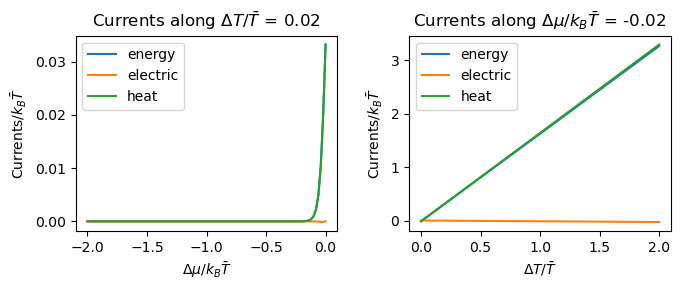

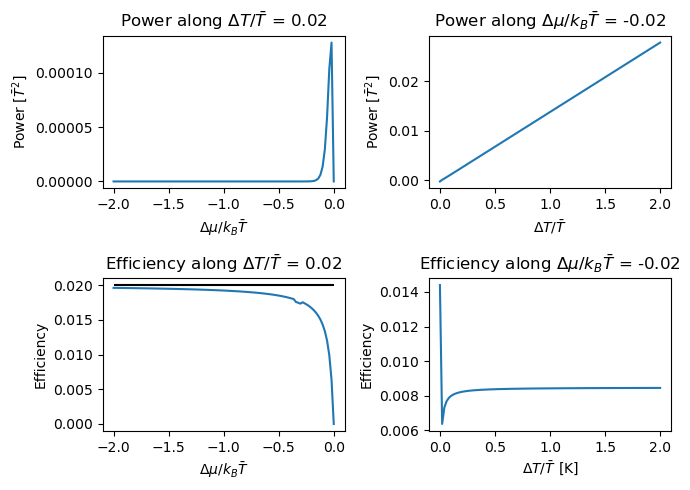

In [90]:
# Plotting power and efficiency
power = -e*(r_muL-muR)*r_electric

#eff = power/r_heat
eff = np.divide(power, r_heat, where = r_heat !=0)
bad_eff = np.where(np.abs(eff) > 1)
#eff[bad_eff] = np.nan
#print(f"The efficiency is {eff}")

#print(r_electric[10,0])
#print(r_heat[10,0])
#print(r_energy[10,0])

T_idx = 1
mu_idx = 1
#print(f"The generated power is {power[T_idx,:]}")
#print(r_heat[T_idx,:])

print(r_E0)
#carnot = 

fig, axs = plt.subplots(1,2, figsize=(7,3))
axs[0].set_title(rf"Currents along $\Delta T / \bar T$ = {r_deltaT[T_idx]:.2f}")
axs[0].plot(r_deltamu, r_energy[T_idx,:], label = "energy")
axs[0].plot(r_deltamu, e*(r_deltamu+mu)*r_electric[T_idx,:], label = "electric")
axs[0].plot(r_deltamu, r_heat[T_idx,:], label = "heat")
axs[0].set_xlabel(rf"$\Delta \mu / k_B \bar T$")
axs[0].set_ylabel(rf"Currents/$k_B \bar T$")
axs[0].legend()
axs[1].set_title(rf"Currents along $\Delta \mu / k_B \bar T$ = {r_deltamu[mu_idx]:.2f}")
axs[1].plot(r_deltaT, r_energy[:,mu_idx], label = "energy")
axs[1].plot(r_deltaT, e*(r_deltamu[mu_idx]+mu)*r_electric[:, mu_idx], label = "electric")
axs[1].plot(r_deltaT, r_heat[:,mu_idx], label = "heat")
axs[1].set_xlabel(rf"$\Delta T / \bar T$")
axs[1].set_ylabel(rf"Currents/$k_B \bar T$")
axs[1].legend()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2,2, figsize=(7,5))
axs[0,0].set_title(rf"Power along $\Delta T / \bar T$ = {r_deltaT[T_idx]:.2f}")
axs[0,0].plot(r_deltamu, (power[T_idx,:]))
axs[0,0].set_xlabel(rf"$\Delta \mu / k_B \bar T$")
axs[0,0].set_ylabel(rf"Power [$\bar T^2$]")
axs[0,1].set_title(rf"Power along $\Delta \mu/k_B \bar T$ = {r_deltamu[mu_idx]:.2f}")
axs[0,1].plot(r_deltaT, power[:,mu_idx])
axs[0,1].set_xlabel(rf"$\Delta T / \bar T$")
axs[0,1].set_ylabel(rf"Power [$\bar T^2$]")
axs[1,0].set_title(rf"Efficiency along $\Delta T / \bar T$ = {r_deltaT[T_idx]:.2f}")
axs[1,0].plot(r_deltamu, eff[T_idx,:])
axs[1,0].hlines(carnot(r_TL[T_idx], r_TR[T_idx]), r_deltamu[0], r_deltamu[-1], colors = 'black')
axs[1,0].set_xlabel(rf"$\Delta \mu/k_B \bar T$")
axs[1,0].set_ylabel(rf"Efficiency")
axs[1,1].set_title(rf"Efficiency along $\Delta \mu/k_B \bar T$ = {r_deltamu[mu_idx]:.2f}")
axs[1,1].plot(r_deltaT, eff[:,mu_idx])
axs[1,1].set_xlabel(rf"$\Delta T / \bar T$ [K]")
axs[1,1].set_ylabel(rf"Efficiency")
plt.tight_layout()
plt.show()


## Arbitrary transmission function

While the band pass structure for transmission functions is well known to be optimal for currents between thermal baths, for potential non-thermal baths, this is no longer guaranteed. In preparation of analyzing non-thermal baths, we try to numerically find the ideal transmission function and compare with the band pass. Hopefully, the optimization should yield a suitable band pass as transmission function, with some room for error

In [97]:

E_start = 0; E_stop = 5
n_chunks = 100
deltaE = (E_stop-E_start)/n_chunks
#if (E_start-E_stop) % deltaE != 0:
#    print("Invalid energy range")
#n_chunks = int((E_stop-E_start)/deltaE)

E_range = np.linspace(E_start,E_stop,n_chunks)
E_mids = (E_range[:-1]+E_range[1:])/2


In [92]:
# Learning a distribution without (with weaker) prior assumptions...
# Gaussian processes, Bayesian loop? What is our data and what is our input? Preferably without using formulas for max possible efficiency and power (except Carnot limit)
# Let's start by rewriting what we did above, but dividing T_LR into chunks

def chunk_current_integral(transf,E_mids,muL, TL ,muR, TR, occupf = fermi_dist, type = "electric"):
    if type == "electric":
        coeff = lambda E: e
    elif type == "heat":
        coeff = lambda E: (E-muL)
    elif type == "heatR":
        coeff = lambda E: (E-muR)
    elif type == "energy":
        coeff = lambda E: E
    else:
        print("Invalid current type")
        return -1

    if type == "heatR":
        occupdiff = -occupf(E_mids,muL,TL)+ occupf(E_mids,muR,TR)
    else:    
        occupdiff = occupf(E_mids,muL,TL)- occupf(E_mids,muR,TR)

    integrands = 1/h*coeff(E_mids)*transf*occupdiff*deltaE
    
    # If we have a delta function?
    #if E1 - E0 < 1:
    #    return integrand((E0+E1)/2)*(E0+E1)/2

    current = np.sum(integrands)
    return current
    
def chunk_maximize_eff(transf, E_mids, muL, TL ,muR, TR):
    electric = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, type = "electric")
    heat = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, type = "heat")
    power = -e*(muL-muR)*electric
    #if heat == 0:
    #    return np.inf
    eff = power/heat
    #if np.abs(eff) > 1:
    #    return np.inf
    return -eff

def chunk_maximize_power(transf, E_mids, muL, TL ,muR, TR):
    electric = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, type = "electric")
    power = -e*(muL-muR)*electric
    #if target_eff > 0:
    #    heat = w_simple_current(E, deltamu, deltaT, type = "heat")
    #    eff = power/heat
    return -power

def chunk_eff_constraint(transf, E_mids, muL, TL ,muR, TR, target_eff):
    electric = chunk_current_integral(transf,E_mids, muL, TL ,muR, TR, type = "electric")
    heat = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, type = "heat")
    power = -e*(muL-muR)*electric
    eff = power/heat if heat != 0 else -1
    return target_eff - eff


True
Optimization terminated successfully
Temperature bias: 0.3030303030303031
Potential bias: -0.20202020202020177
Exchange energy: 0.5656565656565649

From chunk optimization:
Power output: 0.0065889937092696305
Efficiency: 0.1315789601569399 (Target efficieny: 0.13157894736842107)

From regular optimization
Power: 0.025367008683934378
Eff: 0.06769241739261582


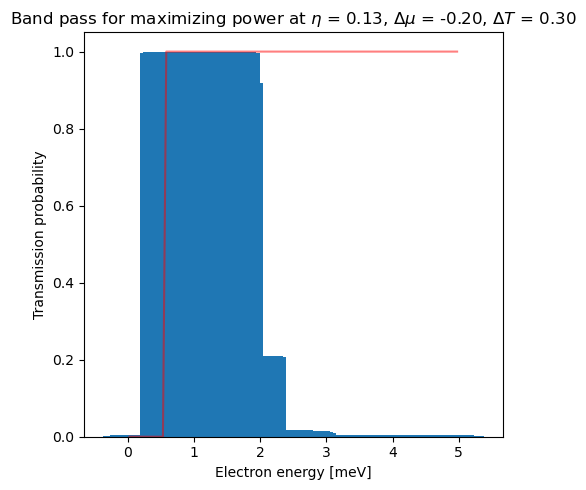

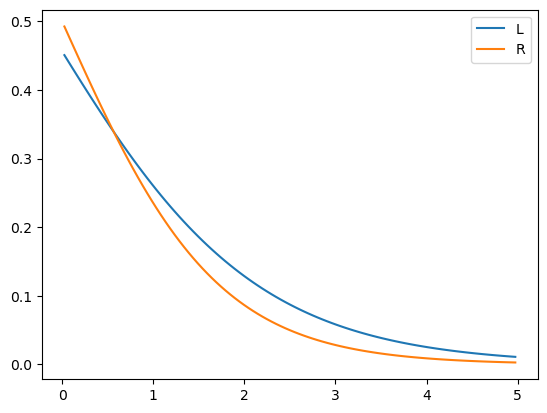

In [102]:
#TODO: Maximize efficiency for target power (how to decide a reasonable power output?)
init_transf = np.random.uniform(0,1,len(E_mids))
T_idx = 15
mu_idx = 10
muL = r_muL[mu_idx]
TL = r_TL[T_idx]
TR = r_TR[T_idx]
target_eff = 0.5*carnot(TL,TR)
res = minimize(chunk_maximize_power, init_transf, args = (E_mids, muL, TL ,muR, TR), bounds=(((0,1),)*len(E_mids)),
               constraints = [{'type':'eq', 'fun': chunk_eff_constraint, 'args':(E_mids, muL, TL ,muR, TR, target_eff)}])
transf = res.x
print(res.success)
print(res.message)
electric = chunk_current_integral(transf,E_mids, muL, TL ,muR, TR,  type = "electric")
heat = chunk_current_integral(transf, E_mids, muL, TL ,muR, TR, type = "heat")
power_ch = -(muL-muR)*electric
eff_ch = power_ch/heat

#TODO: Compare with exact solution
print(f"Temperature bias: {TL-TR}")
print(f"Potential bias: {muL-muR}")
print(f"Exchange energy: {E_max(muL, TL ,muR, TR)}")
print(f"\nFrom chunk optimization:")
print(f"Power output: {power_ch}")
print(f"Efficiency: {eff_ch} (Target efficieny: {target_eff})")
fig = plt.figure(figsize=(5,5))
plt.bar(E_mids, transf)
plt.title(fr"Transmission function maximizing power for given efficieny, $\eta =$ {target_eff:.2f} ")
plt.ylabel(f"Transmission probability")
plt.xlabel("Electron energy [meV]")
#plt.show()
# Visualize bandpasses
r_E = E_mids#np.linspace(0, 100,1000)
E0 = r_E0[T_idx, mu_idx].reshape(-1,1)
E1 = r_E1[T_idx, mu_idx].reshape(-1,1)
band = (np.heaviside(r_E-E0,1)*np.heaviside(E1-r_E,1))

#print(E0)
#print(E1)
print(f"\nFrom regular optimization")
print(f"Power: {power[T_idx, mu_idx]}")
print(f"Eff: {eff[T_idx, mu_idx]}")
#fig = plt.figure()
plt.plot(r_E, band.T, 'r', alpha = 0.5)
plt.title(rf"Band pass for maximizing power at $\eta$ = {target_eff:.2f}, $\Delta \mu$ = {r_deltamu[mu_idx]:.2f}, $\Delta T$ = {r_deltaT[T_idx]:.2f}")
plt.ylabel("Transmission probability")
plt.xlabel("Electron energy [meV]")
plt.tight_layout()

plt.show()

plt.plot(r_E, fermi_dist(r_E, muL, TL), label = "L")
plt.plot(r_E, fermi_dist(r_E, muR, TR), label = "R")
plt.legend()
plt.show()


In [94]:
# Calculate J_e = 0 curve
Je_zero_idx = []
for i, deltaT in enumerate(r_deltaT):
    flip_idx = np.where(power[i,:-1]*power[i,1:] < 0)[0] + 1
    if flip_idx.size > 0:
        flip_idx=flip_idx[0]
        Je_zero_idx.append(flip_idx if np.abs(power[i,flip_idx]) < power[i,flip_idx-1] else flip_idx-1)
        print(power[i, Je_zero_idx])
    else:
        Je_zero_idx.append(0)
Je_zero = r_electric[:, Je_zero_idx]
print(Je_zero)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.01400297 0.01400297 0.01400297 ... 0.01400297 0.01400297 0.01400297]
 [0.02800595 0.02800595 0.02800595 ... 0.02800595 0.02800595 0.02800595]
 ...
 [1.35828841 1.35828841 1.35828841 ... 1.35828841 1.35828841 1.35828841]
 [1.37229139 1.37229139 1.37229139 ... 1.37229139 1.37229139 1.37229139]
 [1.38629436 1.38629436 1.38629436 ... 1.38629436 1.38629436 1.38629436]]


/tmp/ipykernel_8676/3072341112.py:16: RuntimeWarning: invalid value encountered in divide
  r_S = -r_deltamu[Je_zero_idx]/r_deltaT
/tmp/ipykernel_8676/3072341112.py:21: RuntimeWarning: invalid value encountered in divide
  r_PI = r_heat[0,:]/r_electric[0,:]
/tmp/ipykernel_8676/3072341112.py:22: RuntimeWarning: invalid value encountered in scalar divide
  r_K = [r_heat[i,Je_zero_idx[i]]/r_deltaT[i] for i in range(len(r_deltaT))]


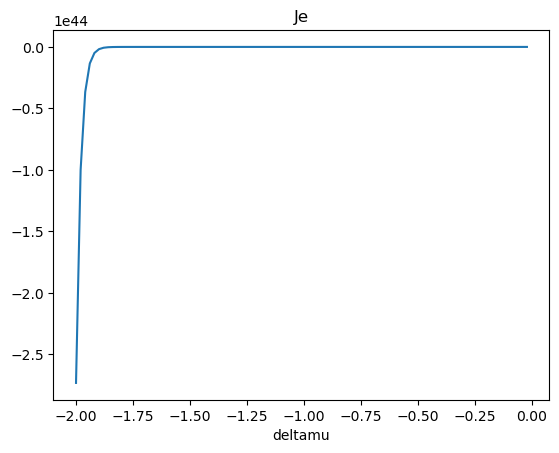

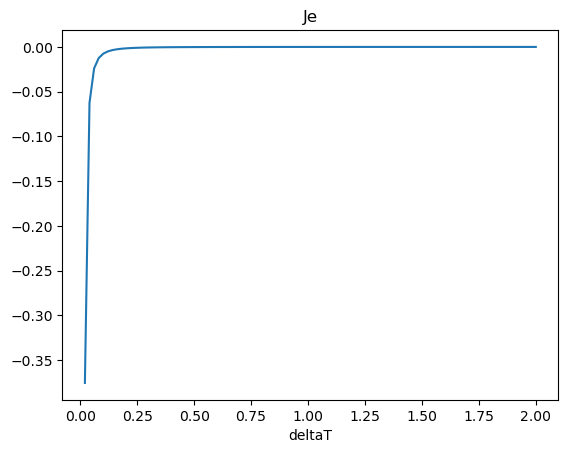

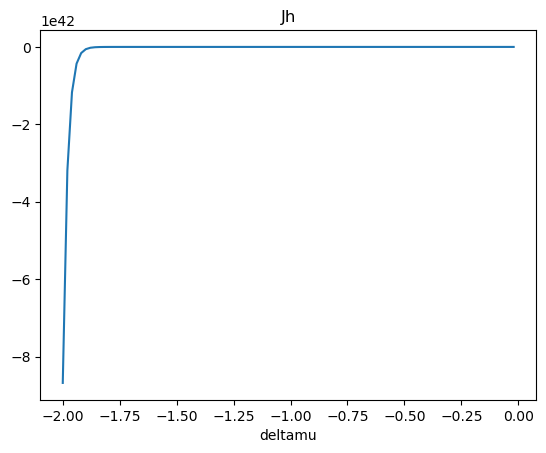

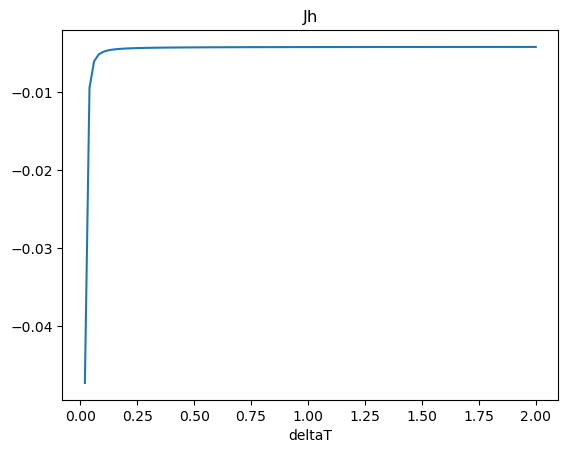

In [95]:
#Time to calculate the transport coefficients and check their asymptotic behaviors!
r_G = r_electric[0,1:]/r_deltamu[1:]
#Divide along the column

r_L = r_heat[0,1:]/r_deltamu[1:]

r_M = r_electric[1:, 0]/r_deltaT[1:]

r_Kplus = r_heat[1:, 0]/r_deltaT[1:]

diff_Je = ((r_G*r_deltamu[1:] + (r_M*r_deltaT[1:]).reshape(-1,1)) - r_electric[1:,1:])/r_electric[1:,1:]
diff_Jh = ((r_L*r_deltamu[1:] + (r_Kplus*r_deltaT[1:]).reshape(-1,1)) - r_heat[1:,1:])/r_heat[1:,1:]
check_Je = np.all(diff_Je < 1e-10)
check_Jh = np.all(diff_Jh < 1e-10)
#r_S = (r_M.reshape(-1,1)/r_G).T
r_S = -r_deltamu[Je_zero_idx]/r_deltaT
#r_K = r_heat[1:,:]/r_deltaT[1:].reshape(-1,1)

#r_S = -(r_deltamu[1:])/r_deltaT[1:].reshape(-1,1)

r_PI = r_heat[0,:]/r_electric[0,:]
r_K = [r_heat[i,Je_zero_idx[i]]/r_deltaT[i] for i in range(len(r_deltaT))]
#r_K = r_Kplus - r_G*r_S*r_PI[1:]

fig = plt.figure()
plt.plot(r_deltamu[1:], diff_Je[0,:])
plt.title("Je")
plt.xlabel("deltamu")
plt.show()
fig = plt.figure()
plt.plot(r_deltaT[1:], diff_Je[:,0])
plt.title("Je")
plt.xlabel("deltaT")
plt.show()
fig = plt.figure()
plt.title("Jh")
plt.plot(r_deltamu[1:], diff_Jh[0,:])
plt.xlabel("deltamu")
plt.show()
fig = plt.figure()
plt.title("Jh")
plt.xlabel("deltaT")
plt.plot(r_deltaT[1:], diff_Jh[:,0])
plt.show()


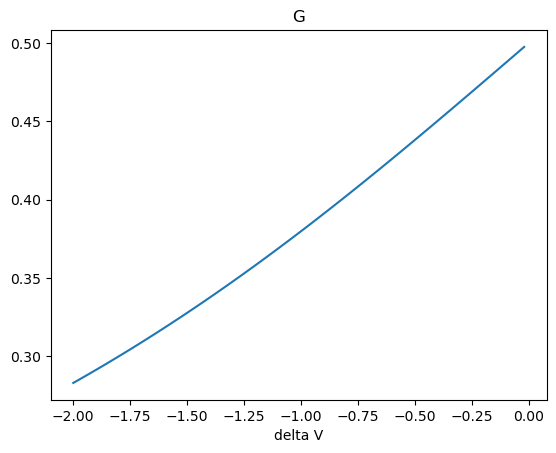

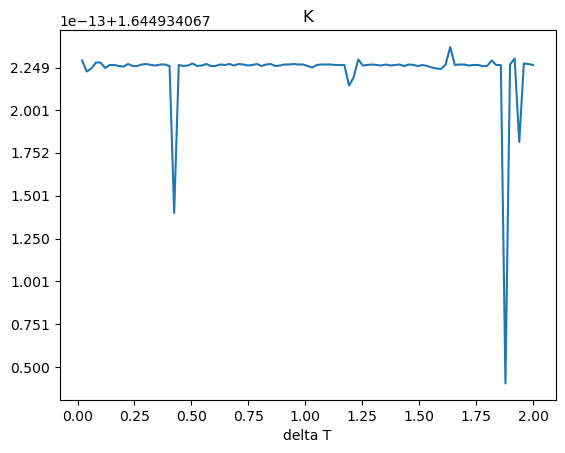

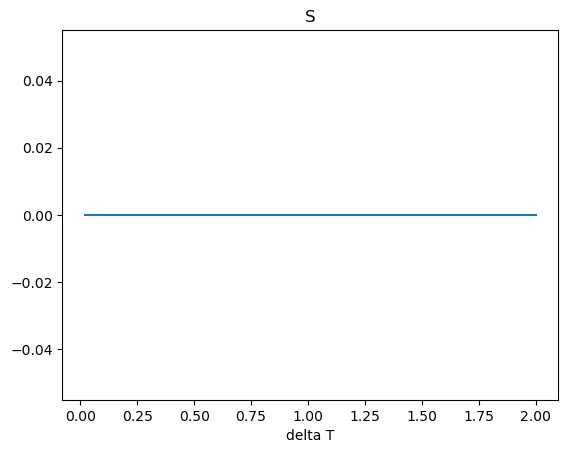

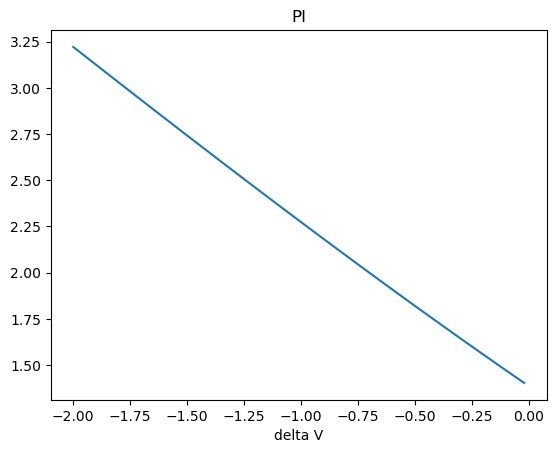

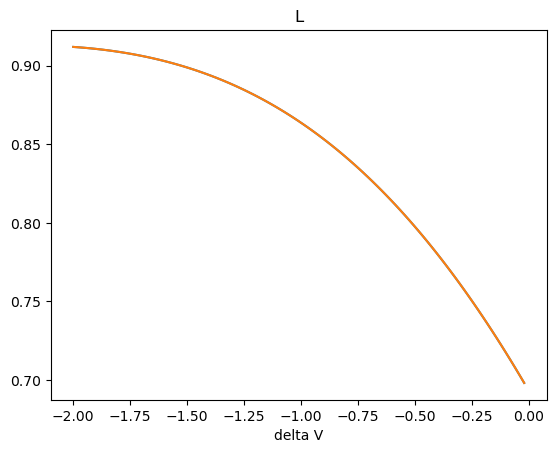

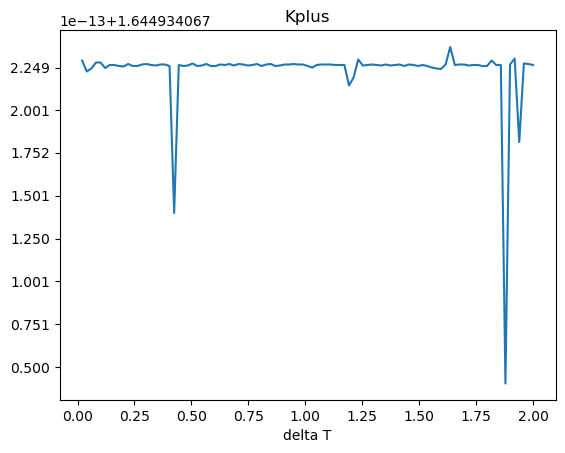

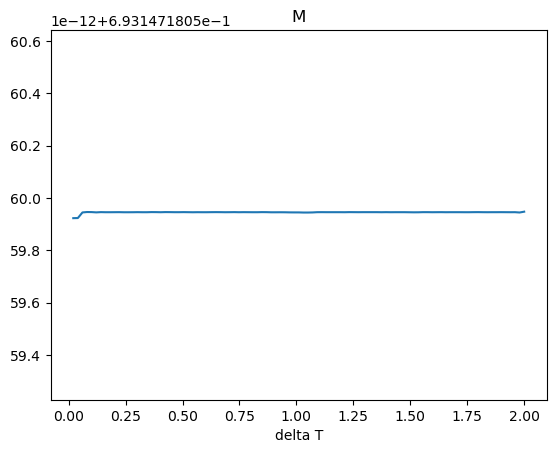

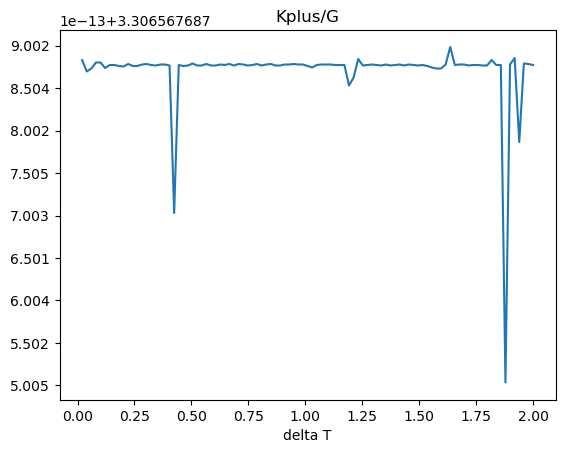

In [96]:
fig = plt.figure()
#plt.plot(r_electric[0,1:], r_G)
plt.plot(r_deltamu[1:], r_G)
plt.title("G")
plt.xlabel("delta V")
plt.show()
fig = plt.figure()
#plt.plot(r_electric[0,1:], r_G)
plt.plot(r_deltaT, r_K) #label = r_deltamu[0:10])
plt.title("K")
plt.xlabel("delta T")
plt.show()

fig = plt.figure()
plt.plot(r_deltaT, r_S)#, label = r_deltamu[1:10])
plt.title("S")
plt.xlabel("delta T")
plt.show()

fig = plt.figure()
plt.plot(r_deltamu, r_PI)
plt.title("PI")
plt.xlabel("delta V")
plt.show()

fig = plt.figure()
plt.plot(r_deltamu[1:], r_PI[1:]*r_G)
plt.plot(r_deltamu[1:], r_L)
plt.title("L")
plt.xlabel("delta V")
plt.show()

fig = plt.figure()
plt.plot(r_deltaT[1:], r_Kplus)
plt.title("Kplus")
plt.xlabel("delta T")
plt.show()

fig = plt.figure()
plt.plot(r_deltaT[1:], r_M)
plt.title("M")
plt.xlabel("delta T")
plt.show()

fig = plt.figure()
plt.plot(r_deltaT[1:], (r_Kplus.reshape(-1,1)/r_G)[:,0])
plt.title("Kplus/G")
plt.xlabel("delta T")
plt.show()